# Libraries

In [1]:
import scipy.io as sio
import sys

import pandas as pd
import numpy as np

import statsmodels.tsa.stattools as tsa
from statsmodels.tsa.api import VAR
import statistics

sys.path.insert(0, '../../Libraries')
import JacksonsTSPackage as jts
from ltar import LTAR, diff, invert_diff

In [2]:
sst = sio.loadmat('data/sst.mat')
sst

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:14:49 2013',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[array([[28.15, 28.27, 28.05, 28.39, 28.67, 29.26],
        [28.43, 28.81, 27.88, 28.09, 27.12, 26.99],
        [28.12, 27.69, 28.03, 26.9 , 25.84, 24.95],
        [28.56, 28.36, 28.44, 28.35, 27.3 , 25.71],
        [29.29, 29.73, 29.18, 28.41, 27.63, 27.01]])],
        [array([[28.16, 28.27, 28.06, 28.53, 28.68, 29.44],
        [28.43, 28.81, 27.89, 28.09, 27.19, 27.12],
        [28.11, 27.7 , 28.  , 26.93, 26.02, 25.07],
        [28.56, 28.34, 28.45, 28.47, 27.41, 25.83],
        [29.31, 29.76, 29.18, 28.55, 27.63, 27.01]])],
        [array([[28.19, 28.3 , 28.09, 28.65, 28.68, 29.66],
        [28.44, 28.81, 27.93, 28.09, 27.42, 27.33],
        [28.13, 27.74, 28.05, 27.03, 26.17, 25.14],
        [28.57, 28.33, 28.52, 28.6 , 27.55, 25.98],
        [29.34, 29.83, 29.22, 28.74, 27.63, 27.01]])],
        ...,
        [array([[29.58, 29.12,

In [3]:
N = len(sst['X'])
N_train = 1800
N_test = N - N_train
print(f"N: {N}")
print(f"N_train: {N_train}")
print(f"N_test: {N_test}")

N: 2000
N_train: 1800
N_test: 200


In [4]:
tensor_shape = (len(sst['X']), sst['X'][0][0].shape[0], sst['X'][0][0].shape[1])
tensor_shape

(2000, 5, 6)

In [5]:
tensor_data = np.zeros(tensor_shape)
for i in range(tensor_shape[0]):
    tensor_data[i] = sst['X'][i][0]
tensor_data

array([[[28.15, 28.27, 28.05, 28.39, 28.67, 29.26],
        [28.43, 28.81, 27.88, 28.09, 27.12, 26.99],
        [28.12, 27.69, 28.03, 26.9 , 25.84, 24.95],
        [28.56, 28.36, 28.44, 28.35, 27.3 , 25.71],
        [29.29, 29.73, 29.18, 28.41, 27.63, 27.01]],

       [[28.16, 28.27, 28.06, 28.53, 28.68, 29.44],
        [28.43, 28.81, 27.89, 28.09, 27.19, 27.12],
        [28.11, 27.7 , 28.  , 26.93, 26.02, 25.07],
        [28.56, 28.34, 28.45, 28.47, 27.41, 25.83],
        [29.31, 29.76, 29.18, 28.55, 27.63, 27.01]],

       [[28.19, 28.3 , 28.09, 28.65, 28.68, 29.66],
        [28.44, 28.81, 27.93, 28.09, 27.42, 27.33],
        [28.13, 27.74, 28.05, 27.03, 26.17, 25.14],
        [28.57, 28.33, 28.52, 28.6 , 27.55, 25.98],
        [29.34, 29.83, 29.22, 28.74, 27.63, 27.01]],

       ...,

       [[29.58, 29.12, 29.23, 28.31, 27.29, 27.73],
        [29.33, 28.95, 28.56, 25.8 , 25.68, 23.33],
        [29.65, 28.86, 28.2 , 25.91, 23.54, 22.22],
        [30.19, 29.18, 28.15, 26.98, 25.32, 2

<AxesSubplot:>

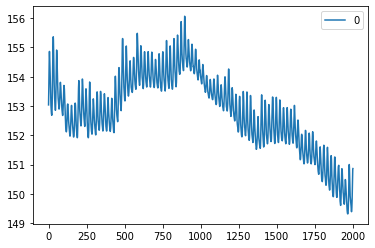

In [6]:
norms = []
for i in range(N):
    norms.append(np.linalg.norm(tensor_data[i], ord="fro"))
pd.DataFrame(norms).plot()

In [7]:
train_tensor = jts.extract_train_tensor(tensor_data, N_train)
test_tensor = jts.extract_test_tensor(tensor_data, N_train, N_test)

In [8]:
dct_ltar = LTAR(train_tensor)
dct_ltar.fit(5, "dct")

dct_ltari = LTAR(diff(train_tensor))
dct_ltari.fit(5, "dct")

interval = 24
dct_lstar = LTAR(diff(train_tensor, interval))
dct_lstar.fit(5, "dct")

In [9]:
dct_result_tensor = dct_ltar.forecast(N_test)
dcti_result_tensor = invert_diff(dct_ltari.forecast(N_test), train_tensor)
dcts_result_tensor = invert_diff(dct_ltari.forecast(N_test), train_tensor, interval)

In [10]:
dct_error = jts.calc_mape_per_matrix(test_tensor, dct_result_tensor)
dct_error = dct_error.rename(columns={"MAPE": "dct-TAR"})
dcti_error = jts.calc_mape_per_matrix(test_tensor, dcti_result_tensor)
dcti_error = dcti_error.rename(columns={"MAPE": "dct-TARI"})
dcts_error = jts.calc_mape_per_matrix(test_tensor, dcts_result_tensor)
dcts_error = dcts_error.rename(columns={"MAPE": "dct-STAR"})

Text(0, 0.5, 'Error')

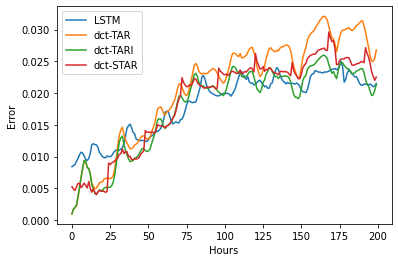

In [11]:
sst_err = sio.loadmat('data/sst_err.mat')
df = pd.DataFrame(np.transpose(sst_err['err_dct']), index=dct_error.index, columns=["dct-MLDS"])
df1 = pd.DataFrame(np.transpose(sst_err['err_dft']), index=dct_error.index, columns=["dft-MLDS"])
df2 = pd.DataFrame(np.transpose(sst_err['err_dwt']), index=dct_error.index, columns=["dwt-MLDS"])
df3 = pd.read_csv('data/sst_lstm.csv')
del df3['Unnamed: 0']
df = pd.concat([df3, dct_error, dcti_error, dcts_error], axis=1)
ax = df.plot()
ax.set_xlabel("Hours")
ax.set_ylabel("Error")